In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np
from argparse import ArgumentParser, RawDescriptionHelpFormatter
import yaml

%matplotlib inline
import matplotlib.pyplot as plt

### LAB 6:

#### PART A: Model runs for stratiform cloud (V=1m/s) while varying aerosol concentration

In [2]:
V = [1., 1] # updraft speed, m/s
dt = 1.0 # timestep, seconds

S0 = -0.02#, -0.02, -0.02  # Supersaturation, 1-RH (98% here)

dist = pm.distributions.jaenicke_distributions
#maritime: larger particles may be sea salt;  smaller particles may be organic substances
maritime = pm.AerosolSpecies('Maritime', dist['Maritime'], kappa = 1, bins=200)
maritime_m = [maritime]

#Urban: let's assume sulfates from pollution sources
urban = pm.AerosolSpecies('Urban', dist['Urban'], kappa = .9, bins=200)
urban_m = [urban]

dist_c1 = dist
dist_c2 = dist
dist_mar  = dist_c1['Maritime']
dist_urban  = dist_c2['Urban']
dist

{'Polar': MultiModeLognorm| mus = (6.89e-02, 3.75e-01, 4.29e+00), sigmas = (1.76e+00, 2.00e+00, 1.95e+00), Totals = (2.17e+01, 1.86e-01, 3.04e-04) |,
 'Urban': MultiModeLognorm| mus = (6.51e-03, 7.14e-03, 2.48e-02), sigmas = (1.76e+00, 4.63e+00, 2.17e+00), Totals = (9.93e+04, 1.11e+03, 3.64e+04) |,
 'Background': MultiModeLognorm| mus = (3.60e-03, 1.27e-01, 2.59e-01), sigmas = (4.42e+00, 1.79e+00, 2.66e+00), Totals = (1.29e+02, 5.97e+01, 6.35e+01) |,
 'Maritime': MultiModeLognorm| mus = (3.90e-03, 1.33e-01, 2.90e-01), sigmas = (4.54e+00, 1.62e+00, 2.49e+00), Totals = (1.33e+02, 6.66e+01, 3.06e+00) |,
 'Remote Continental': MultiModeLognorm| mus = (1.00e-02, 5.80e-02, 9.00e-01), sigmas = (1.45e+00, 1.65e+00, 2.40e+00), Totals = (3.20e+03, 2.90e+03, 3.00e-01) |,
 'Rural': MultiModeLognorm| mus = (7.39e-03, 1.49e-02, 2.69e-02), sigmas = (1.68e+00, 1.85e+00, 3.61e+00), Totals = (6.65e+03, 1.99e+03, 1.47e+02) |}

##### large number of aerosols:

Text(0, 0.5, 'Aerosl number conc., cm$^{-3}$')

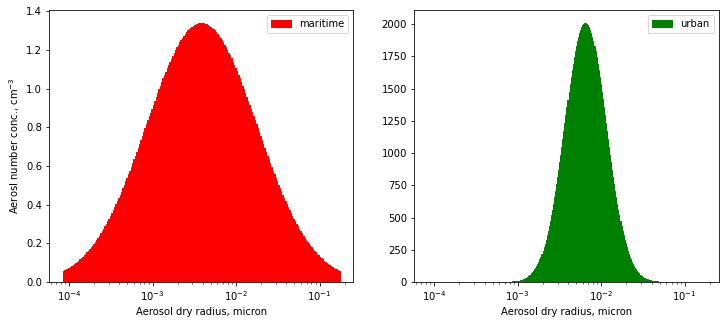

In [9]:
dist_mar.Ns = (1.33e+02)
dist_mar.sigmas = (4.54e+00)
dist_mar.mus = (3.90e-03)

dist_urban.Ns =(9.93e+04)
dist_urban.sigmas = (1.76e+00)
dist_urban.mus = (6.51e-03)

maritime = pm.AerosolSpecies('Maritime', pm.Lognorm(mu=dist_mar.mus, sigma=dist_mar.sigmas, N=dist_mar.Ns), kappa = 1., bins=200)
maritime_m = [maritime]

urban = pm.AerosolSpecies('Urban', pm.Lognorm(mu=dist_urban.mus, sigma=dist_urban.sigmas, N=dist_urban.Ns), kappa = .9, bins=200)
urban_m = [urban]

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
ax = axes.flatten()

aerosols_1 = [maritime, urban]
labels = ['maritime','urban']
colors = ['red','green']
for i, aerosol in enumerate(aerosols_1):
    ax[i].grid(False, 'minor')
    ax[i].bar(aerosol.rs[:-1], aerosol.Nis*1e-6, np.diff(aerosol.rs),
        color=colors[i], label=labels[i], edgecolor=colors[i])
    ax[i].semilogx()
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Aerosol dry radius, micron")

ax[0].set_ylabel("Aerosl number conc., cm$^{-3}$")
#plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig1'),bbox_inches='tight',dpi=400)

CDNC(maritime) = 28.1
------------------------
          total = 28.1 / 131 ~ act frac = 0.21

CDNC(urban) = 1116.6
------------------------
          total = 1116.6 / 99314 ~ act frac = 0.01



Text(0, 0.5, 'Height, m')

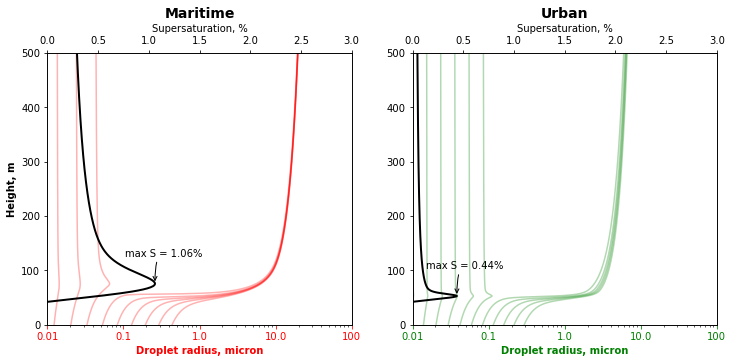

In [10]:
mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print()

ax[0].set_ylabel("Height, m", fontweight='bold')
#plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig2'),bbox_inches='tight',dpi=400)

##### moderate number of aerosols:

Text(0, 0.5, 'Aerosl number conc., cm$^{-3}$')

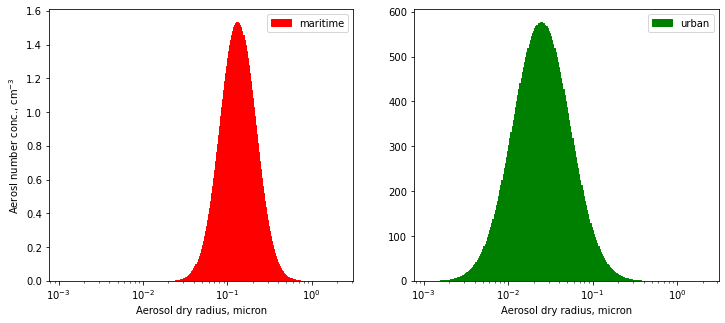

In [5]:
dist_mar.Ns = (6.66e+01)
dist_mar.sigmas = (1.62e+00)
dist_mar.mus = (1.33e-01)

dist_urban.Ns =(3.64e+04)
dist_urban.sigmas = (2.17e+00)
dist_urban.mus = (2.48e-02)

maritime = pm.AerosolSpecies('Maritime', pm.Lognorm(mu=dist_mar.mus, sigma=dist_mar.sigmas, N=dist_mar.Ns), kappa = 1., bins=200)
maritime_m = [maritime]

urban = pm.AerosolSpecies('Urban', pm.Lognorm(mu=dist_urban.mus, sigma=dist_urban.sigmas, N=dist_urban.Ns), kappa = .9, bins=200)
urban_m = [urban]

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
ax = axes.flatten()

aerosols_1 = [maritime, urban]
labels = ['maritime','urban']
colors = ['red','green']
for i, aerosol in enumerate(aerosols_1):
    ax[i].grid(False, 'minor')
    ax[i].bar(aerosol.rs[:-1], aerosol.Nis*1e-6, np.diff(aerosol.rs),
        color=colors[i], label=labels[i], edgecolor=colors[i])
    ax[i].semilogx()
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Aerosol dry radius, micron")

ax[0].set_ylabel("Aerosl number conc., cm$^{-3}$")
#plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig3'),bbox_inches='tight',dpi=400)

CDNC(maritime) = 66.6
------------------------
          total = 66.6 /  67 ~ act frac = 1.00

CDNC(urban) = 3220.7
------------------------
          total = 3220.7 / 36403 ~ act frac = 0.09



Text(0, 0.5, 'Height, m')

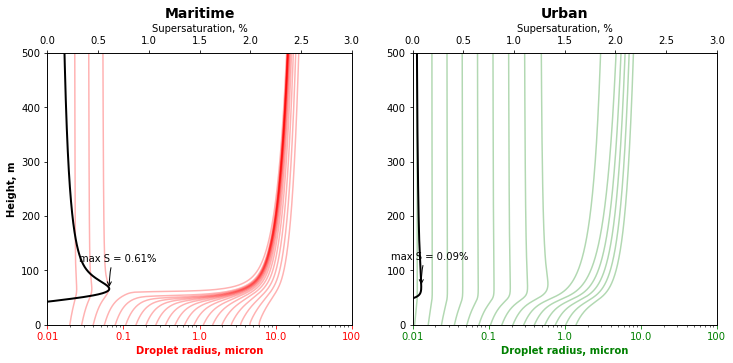

In [6]:
mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print()

ax[0].set_ylabel("Height, m", fontweight='bold')
#plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig4'),bbox_inches='tight',dpi=400)

##### smaller number of aerosols:

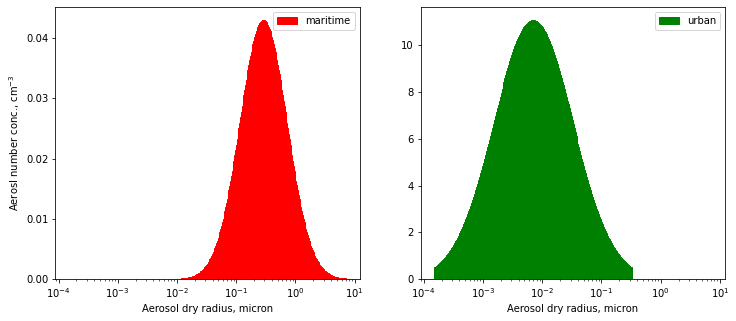

In [7]:
dist_mar.Ns = (3.06e+00)
dist_mar.sigmas = (2.49e+00)
dist_mar.mus = (2.90e-01)

dist_urban.Ns =(1.11e+03)
dist_urban.sigmas = (4.63e+00)
dist_urban.mus = (7.14e-03)

maritime = pm.AerosolSpecies('Maritime', pm.Lognorm(mu=dist_mar.mus, sigma=dist_mar.sigmas, N=dist_mar.Ns), kappa = 1., bins=200)
maritime_m = [maritime]

urban = pm.AerosolSpecies('Urban', pm.Lognorm(mu=dist_urban.mus, sigma=dist_urban.sigmas, N=dist_urban.Ns), kappa = .9, bins=200)
urban_m = [urban]


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
ax = axes.flatten()

aerosols_1 = [maritime, urban]
labels = ['maritime','urban']
colors = ['red','green']
for i, aerosol in enumerate(aerosols_1):
    ax[i].grid(False, 'minor')
    ax[i].bar(aerosol.rs[:-1], aerosol.Nis*1e-6, np.diff(aerosol.rs),
        color=colors[i], label=labels[i], edgecolor=colors[i])
    ax[i].semilogx()
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Aerosol dry radius, micron")

ax[0].set_ylabel("Aerosl number conc., cm$^{-3}$")
#plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig5'),bbox_inches='tight',dpi=400)

CDNC(maritime) = 3.1
------------------------
          total = 3.1 /   3 ~ act frac = 1.00

CDNC(urban) = 236.3
------------------------
          total = 236.3 / 1097 ~ act frac = 0.22



Text(0, 0.5, 'Height, m')

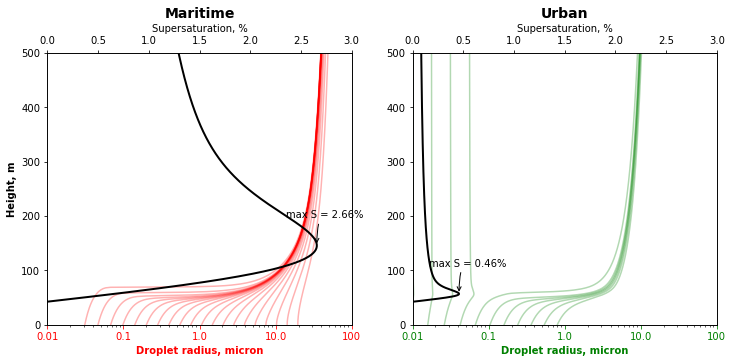

In [8]:
mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print()

ax[0].set_ylabel("Height, m", fontweight='bold')
#plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig6'),bbox_inches='tight',dpi=400)

#### PART B: Model runs for weak vs. moderately (strong) convective clouds (V=3m/s vs. V = 10m/s) while varying aerosol concentration

### weak convective:

CDNC(maritime) = 40.1
------------------------
          total = 40.1 / 131 ~ act frac = 0.30

CDNC(urban) = 2680.4
------------------------
          total = 2680.4 / 99314 ~ act frac = 0.03



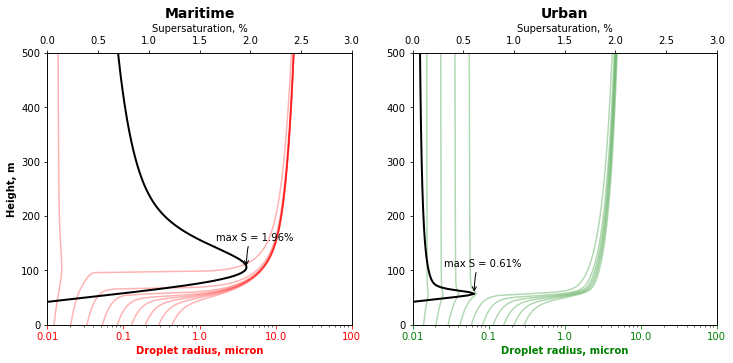

In [7]:
V = [3, 3] # updraft speed, m/s

mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print()

ax[0].set_ylabel("Height, m", fontweight='bold')
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig7'),bbox_inches='tight',dpi=400)

### moderately convective:

CDNC(maritime) = 55.1
------------------------
          total = 55.1 / 131 ~ act frac = 0.42
3.997766082526783
CDNC(urban) = 5758.1
------------------------
          total = 5758.1 / 99314 ~ act frac = 0.06
0.8123710683902133


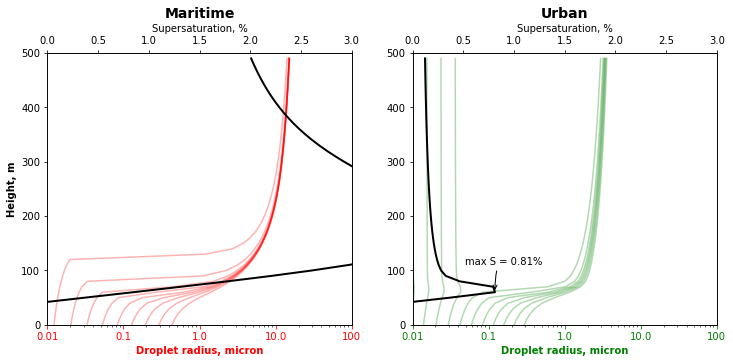

In [12]:
V = [10, 10] # updraft speed, m/s

mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print(Smax)

ax[0].set_ylabel("Height, m", fontweight='bold')
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig8'),bbox_inches='tight',dpi=400)

#### PART C: Model runs for different kappa values in stratiform clouds (V=1m/s) while keeping aerosol concentration constant

##### kappa values of 0.3 for maritime and 0.2 for Urban:

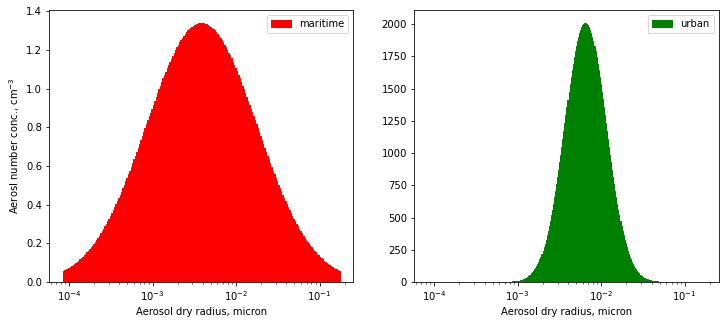

In [11]:
dist_mar.Ns = (1.33e+02)
dist_mar.sigmas = (4.54e+00)
dist_mar.mus = (3.90e-03)

dist_urban.Ns =(9.93e+04)
dist_urban.sigmas = (1.76e+00)
dist_urban.mus = (6.51e-03)

maritime = pm.AerosolSpecies('Maritime', pm.Lognorm(mu=dist_mar.mus, sigma=dist_mar.sigmas, N=dist_mar.Ns), kappa = .3, bins=200)
maritime_m = [maritime]

urban = pm.AerosolSpecies('Urban', pm.Lognorm(mu=dist_urban.mus, sigma=dist_urban.sigmas, N=dist_urban.Ns), kappa = .2, bins=200)
urban_m = [urban]

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
ax = axes.flatten()

aerosols_1 = [maritime, urban]
labels = ['maritime','urban']
colors = ['red','green']
for i, aerosol in enumerate(aerosols_1):
    ax[i].grid(False, 'minor')
    ax[i].bar(aerosol.rs[:-1], aerosol.Nis*1e-6, np.diff(aerosol.rs),
        color=colors[i], label=labels[i], edgecolor=colors[i])
    ax[i].semilogx()
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Aerosol dry radius, micron")

ax[0].set_ylabel("Aerosl number conc., cm$^{-3}$")
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig9'),bbox_inches='tight',dpi=400)

CDNC(maritime) = 20.9
------------------------
          total = 20.9 / 131 ~ act frac = 0.16

CDNC(urban) = 306.4
------------------------
          total = 306.4 / 99314 ~ act frac = 0.00



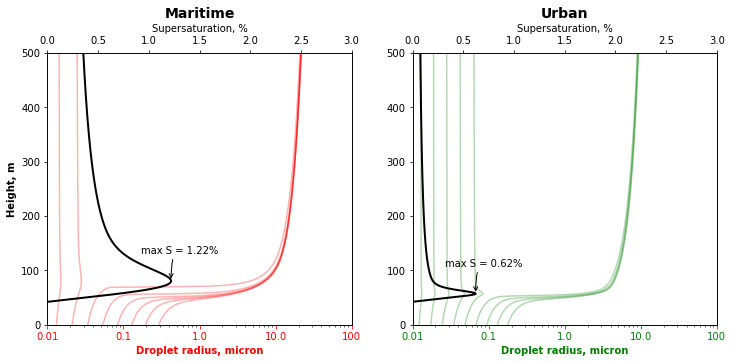

In [12]:
mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print()

ax[0].set_ylabel("Height, m", fontweight='bold')
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig10'),bbox_inches='tight',dpi=400)

##### kappa values of 0.6 for maritime and 0.5 for Urban:

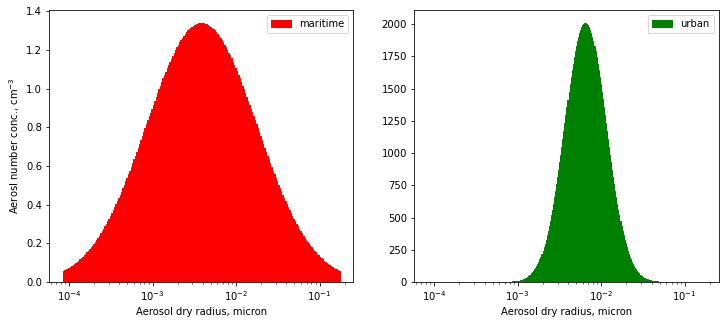

In [13]:
dist_mar.Ns = (1.33e+02)
dist_mar.sigmas = (4.54e+00)
dist_mar.mus = (3.90e-03)

dist_urban.Ns =(9.93e+04)
dist_urban.sigmas = (1.76e+00)
dist_urban.mus = (6.51e-03)

maritime = pm.AerosolSpecies('Maritime', pm.Lognorm(mu=dist_mar.mus, sigma=dist_mar.sigmas, N=dist_mar.Ns), kappa = .6, bins=200)
maritime_m = [maritime]

urban = pm.AerosolSpecies('Urban', pm.Lognorm(mu=dist_urban.mus, sigma=dist_urban.sigmas, N=dist_urban.Ns), kappa = .5, bins=200)
urban_m = [urban]

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
ax = axes.flatten()

aerosols_1 = [maritime, urban]
labels = ['maritime','urban']
colors = ['red','green']
for i, aerosol in enumerate(aerosols_1):
    ax[i].grid(False, 'minor')
    ax[i].bar(aerosol.rs[:-1], aerosol.Nis*1e-6, np.diff(aerosol.rs),
        color=colors[i], label=labels[i], edgecolor=colors[i])
    ax[i].semilogx()
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Aerosol dry radius, micron")

ax[0].set_ylabel("Aerosl number conc., cm$^{-3}$")
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig11'),bbox_inches='tight',dpi=400)

CDNC(maritime) = 25.3
------------------------
          total = 25.3 / 131 ~ act frac = 0.19

CDNC(urban) = 643.4
------------------------
          total = 643.4 / 99314 ~ act frac = 0.01



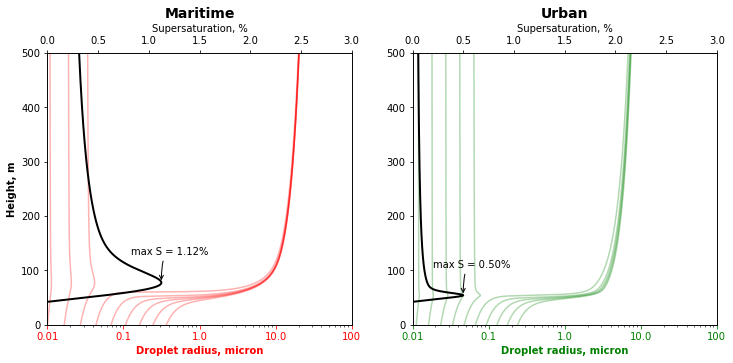

In [14]:
mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print()

ax[0].set_ylabel("Height, m", fontweight='bold')
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig12'),bbox_inches='tight',dpi=400)

##### kappa values of 1.5 for maritime and 1.5 for Urban:

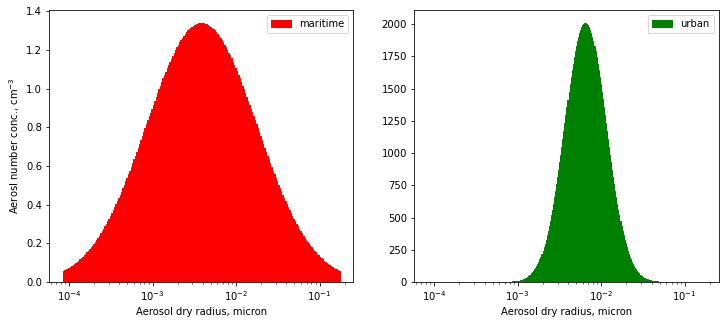

In [15]:
dist_mar.Ns = (1.33e+02)
dist_mar.sigmas = (4.54e+00)
dist_mar.mus = (3.90e-03)

dist_urban.Ns =(9.93e+04)
dist_urban.sigmas = (1.76e+00)
dist_urban.mus = (6.51e-03)

maritime = pm.AerosolSpecies('Maritime', pm.Lognorm(mu=dist_mar.mus, sigma=dist_mar.sigmas, N=dist_mar.Ns), kappa = 1.5, bins=200)
maritime_m = [maritime]

urban = pm.AerosolSpecies('Urban', pm.Lognorm(mu=dist_urban.mus, sigma=dist_urban.sigmas, N=dist_urban.Ns), kappa = 1.5, bins=200)
urban_m = [urban]

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
ax = axes.flatten()

aerosols_1 = [maritime, urban]
labels = ['maritime','urban']
colors = ['red','green']
for i, aerosol in enumerate(aerosols_1):
    ax[i].grid(False, 'minor')
    ax[i].bar(aerosol.rs[:-1], aerosol.Nis*1e-6, np.diff(aerosol.rs),
        color=colors[i], label=labels[i], edgecolor=colors[i])
    ax[i].semilogx()
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Aerosol dry radius, micron")

ax[0].set_ylabel("Aerosl number conc., cm$^{-3}$")
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig13'),bbox_inches='tight',dpi=400)

CDNC(maritime) = 31.2
------------------------
          total = 31.2 / 131 ~ act frac = 0.24

CDNC(urban) = 1647.6
------------------------
          total = 1647.6 / 99314 ~ act frac = 0.02



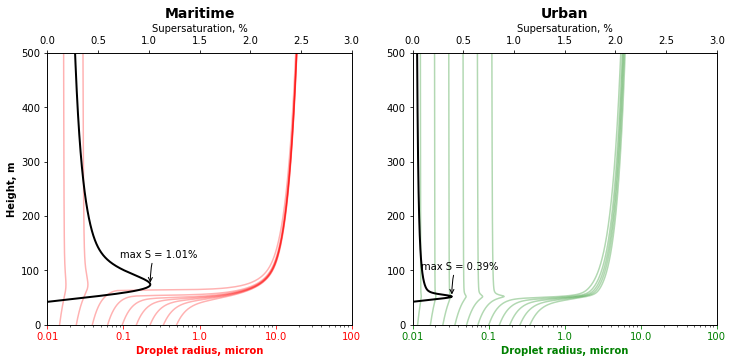

In [16]:
mari_P0, mari_T0, mari_t_end = 90000, 283, 500/V[0]
mari_model = pm.ParcelModel(maritime_m, V[0], mari_T0, S0, mari_P0,console=False, accom = 0.3)

urban_P0, urban_T0, urban_t_end = 98000, 283, 500/V[1]
urban_model = pm.ParcelModel(urban_m, V[1], urban_T0, S0, urban_P0,console=False, accom = 0.3)


fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)
fig.subplots_adjust(hspace=0.2)
ax = axes.flatten()

aerosols = [maritime, urban]
aerosol_models = [mari_model, urban_model]
model_t_ends = [mari_t_end, urban_t_end]
Labels = ['Maritime', 'Urban']
colors = ['red', 'green']
for i, aerosol_model in enumerate(aerosol_models):
    #run the parcel model
    parcel_trace, aerosol_traces = aerosol_model.run(model_t_ends[i], dt, solver='cvode')
    
    aerosol_array = aerosol_traces[Labels[i]].values
    ax[i].plot(aerosol_array[:, ::10]*1e6, parcel_trace['z'], color=colors[i],
         label=Labels[i], alpha = .3)
    ax[i].semilogx()
    ax[i].set_xlim(1e-2, 100.)
    ax[i].set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
    ax[i].set_ylim(0, 500)
    
    
    ax_drop_s = ax[i].twiny()
    ax_drop_s.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
    Smax = parcel_trace['S'].max()*100
    z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
    ax_drop_s.annotate("max S = %0.2f%%" % Smax,
                 xy=(Smax, z_at_smax),
                 xytext=(Smax-0.3, z_at_smax+50.),
                 arrowprops=dict(arrowstyle="->", color='k',
                                 connectionstyle='angle3,angleA=0,angleB=90'),
                 zorder=10)
    
    ax_drop_s.set_xlim(0, 3)
    ax[i].xaxis.label.set_color(colors[i])
    ax[i].tick_params(axis='x', colors=colors[i])
    ax_drop_s.set_xlabel("Supersaturation, %")
            
    for axx in [ax[i], ax_drop_s]:
        axx.grid(False, 'both')
        
    ax[i].set_title(Labels[i], fontsize = 14, fontweight='bold')
    ax[i].set_xlabel("Droplet radius, micron",fontweight='bold')
    
    aerosol_trace = aerosol_traces[Labels[i]]
    ind_final = int(model_t_ends[i]/dt) - 1
    T = parcel_trace['T'].iloc[ind_final]
    
    eq_aerosol, kn_aerosol, alpha_aerosol, phi_aerosol = \
        pm.binned_activation(Smax/100, T, aerosol_trace.iloc[ind_final],  aerosols[i])
    eq_aerosol *= aerosols[i].total_N
    
    print("CDNC("+labels[i]+") = {:3.1f}".format(eq_aerosol))
    print("------------------------")
    print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
          eq_aerosol,
          aerosols[i].total_N,
          (eq_aerosol)/(aerosols[i].total_N)))
    print()

ax[0].set_ylabel("Height, m", fontweight='bold')
plt.savefig('./%s.png' %('plots/Lab6-Afrifa-Fig14'),bbox_inches='tight',dpi=400)